my known lie doesn't make sense anymore? Well truth is when examples of truth are given (and maybe it's asked to tell the truth?) I would need to analyze this seperatly, but getting say N tokens. And trying differen't combinatiuons of system prompt, and n-shot examples


In [1]:
import torch
from IPython.display import display, HTML, Markdown
from torch.utils.data import random_split, DataLoader, TensorDataset
from loguru import logger
import sys
import pandas as pd
import seaborn as sns


logger.remove()
logger.add(sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2
from src.eval.collect import manual_collect2
from src.eval.ds import ds2df, qc_ds, qc_dsdf
from src.prompts.prompt_loading import load_prompts, format_prompt, load_preproc_dataset
from src.models.load import load_model

from matplotlib import pyplot as plt
plt.style.use(['seaborn-v0_8'])


In [2]:
from pathlib import Path
BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/")

## Importance matrix

Wqkv torch.Size([32, 7680])
fc1 torch.Size([32, 10240])
torch.Size([32, 17920])


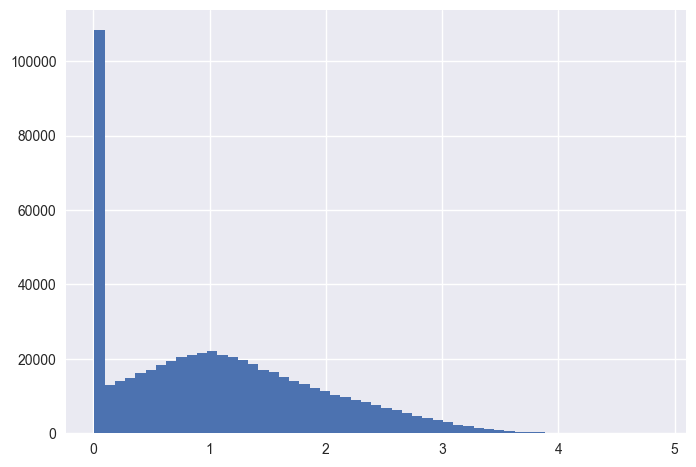

In [3]:
from src.probes.importance_matrix import get_importance_matrix

# f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"

# HACK:
f = "/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_0/checkpoint_last/adapter_model.safetensors"
# +1 because the residuals are a product of diff, so the first row didn't have a diff. So we skip that corresponding first row of the importance matrix
importance_matrix = get_importance_matrix(f, layers=['fc1', 'Wqkv'])#[SKIP+1::STRIDE, ::DECIMATE]
print(importance_matrix.shape)
plt.hist(importance_matrix.flatten(), bins=55);


## Load DS

In [4]:
from datasets import Dataset

f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

ds_val = Dataset.from_file(str(f1_val)).with_format("torch")
ds_oos = Dataset.from_file(str(f1_ood)).with_format("torch")

# ds_known1 = filter_ds_to_known(ds_out, verbose=True)

In [5]:
qc_ds(ds_val)
qc_ds(ds_oos)


with base model
with adapter
with base model
with adapter


({'balance': 0.49600798403193613,
  'N': 1002,
  'auroc': 0.7395008721320274,
  'lie_auroc': 0.2827527322404372,
  'known_lie_auroc': 0.23144220572640511,
  'choice_cov': 0.9787885},
 {'balance': 0.49600798403193613,
  'N': 1002,
  'auroc': 0.7395008721320274,
  'lie_auroc': 0.2827527322404372,
  'known_lie_auroc': 0.23144220572640511,
  'choice_cov': 0.9787885})

In [6]:
def agg_func(x):
    acc = (x.label_instructed == x["ans"]).mean()
    return pd.Series(dict(acc=acc, n=len(x)))

df = ds2df(ds_val)
df = df.rename(columns=lambda x: x.replace("_base", "")).copy()

for col in ["sys_instr_name", "ds_string"]:
    display(df.groupby(col).apply(agg_func))


,acc,n
sys_instr_name,,
default,0.315068,219.0
none,0.497967,492.0
truth,0.695205,292.0


,acc,n
ds_string,,
amazon_polarity,0.525000,200.0
glue:qnli,0.510000,200.0
hans,0.482587,201.0
sst2,0.597015,201.0
super_glue:rte,0.462687,201.0


# Probe

In [7]:
from src.eval.labels import ds2label_model_truth
ds2proxy = ds2label_model_truth
proxy2label = lambda x, ds: x
label_name = "model_truth"

In [8]:
# STRIDE=1
# SKIP=0
# DECIMATE=1
# from typing import Tuple
# from torch import Tensor

# def ds2xy(ds: Dataset, ds2proxy) -> Tuple[Tensor, Tensor]:
#     # x = torch.stack([ds['end_residual_stream_base'], ds['end_residual_stream_adapt']], -1)[:, SKIP::STIDE]
#     X1 = torch.stack([ds['end_residual_fc1_base'], ds['end_residual_fc1_adapt']], dim=-1)
#     X2 = torch.stack([ds['end_residual_Wqkv_base'], ds['end_residual_Wqkv_adapt']], dim=-1)
#     x = torch.concat([X1, X2], dim=2)[:, SKIP::STRIDE, ::DECIMATE] # [layers, features, base/adapt]
#     x = x * importance_matrix[None, :, :, None]**2
#     y = ds2proxy(ds)
#     return x, y


In [9]:
from src.probes.lr import TorchRobustScaler, TorchLogisticRegression, TorchDummyClassifier
from src.helpers.ds import train_test_split_ds
from src.eval.pl_sk import analyze_dfres, SKEvaluator, PlainTruthEval

In [10]:
insample_datasets = list(set(ds_val['ds_string_base']))

In [11]:
evaluator = PlainTruthEval(ds_trainval=ds_val, ds_test=ds_oos, importance_matrix=importance_matrix)
model = TorchLogisticRegression(random_state=42, 
                                max_iter=100,
                                 class_weight='balanced',)
evaluator.eval(model)

In [ ]:
# def test_intervention_quality2(ds_trainval, ds_test, proxy2label, title="", ):
#     if ds_test is None:
#         ds_trainval, ds_test = train_test_split_ds(ds_trainval, test_size=0.2, random_state=42)
#     model = TorchDummyClassifier(random_state=42, strategy="most_frequent")
#     df_res = eval_ranking(model, ds_trainval, ds_test, proxy2label, ds2proxy)
#     analyze_dfres(df_res);


# # model = TorchDummyClassifier(random_state=42, strategy="most_frequent")
# # df_res = eval_ranking(model, ds_trainval, ds_test, proxy2label, ds2proxy)
# # analyze_dfres(df_res);
